In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [41]:
fname = "2020_11_18.hdf"
dset_name = "1605830191 scan J1J2 with ratio"
attr_name = 'SynthHD Pro SetFrequencyCHAGUI'

devices = ()

In [3]:
pmt_channel = 1
shutter_channel = 2

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [44]:
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pmt_data -= pmt_data[:,150:250].mean(axis = 1)[:, np.newaxis]
shutter_data = np.array([pxie[idx][:,shutter_channel].mean() for idx in range(1,len(pxie)+1)])
freq_data = np.array([pxie_attrs[idx][attr_name] for idx in range(1,len(pxie)+1)])

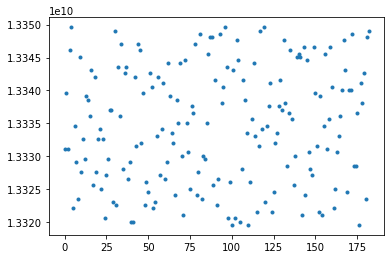

In [49]:
plt.plot(freq_data.reshape(-1,50).mean(axis = 1), '.')

(array([ 265., 3476., 1728.,  909., 1095.,  920.,  497.,  204.,   45.,
          11.]),
 array([-45893.36 ,  -1808.568,  42276.224,  86361.016, 130445.808,
        174530.6  , 218615.392, 262700.184, 306784.976, 350869.768,
        394954.56 ]),
 <BarContainer object of 10 artists>)

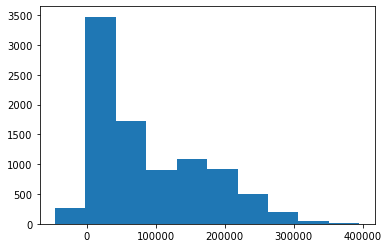

In [84]:
plt.hist(np.trapz(pmt_data, axis = 1))

In [20]:
nbunched = 50
bunched = pmt_data.reshape(-1,nbunched,2000)

In [21]:
def get_shutter_slice(val):
    state = val > 2e4
    if state:
        return np.s_[::2], np.s_[1::2]
    else:
        return np.s_[1::2], np.s_[::2]

In [110]:
integral_limit = 20e3
ratios = []
for idx, bunch in enumerate(bunched):
    slice_open, slice_closed = get_shutter_slice(shutter_data[idx*nbunched])
    mo = bunch[slice_open].mean(axis = 0)
    mc = bunch[slice_closed].mean(axis = 0)
    io = np.trapz(mo)
    ic = np.trapz(mc)
    if (io < integral_limit) or (ic < integral_limit):
        ratios.append(np.nan)
    else:
        ratios.append(io/ic)
ratios = np.array(ratios)

In [111]:
freqs = freq_data.reshape(-1,50).mean(axis = 1)

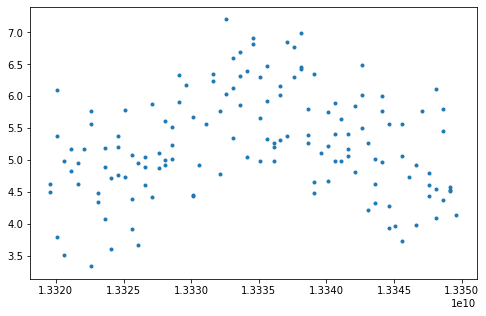

In [112]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(freqs, ratios, '.')

In [113]:
scan_data = {f:[] for f in freqs}
for f,v in zip(freqs, ratios):
    scan_data[f].append(v)

In [114]:
f,v = list(scan_data.keys()), list(scan_data.values())
v = np.nanmean(v, axis = 1)

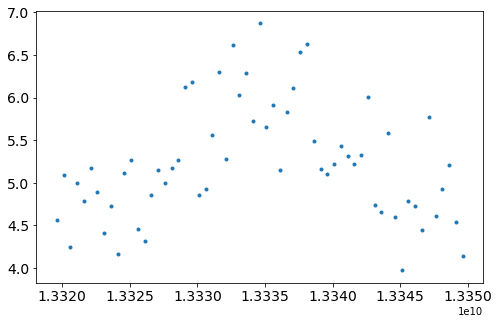

In [115]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(f, v, '.')
set_fontsize(ax, 14)

In [118]:
from astropy import constants
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from astropy.modeling import functional_models

In [119]:
def lorentzian(x, μ, fwhm):
    y = (x-μ)/(fwhm/2)
    return 1/(1+y**2)

13334905795.79


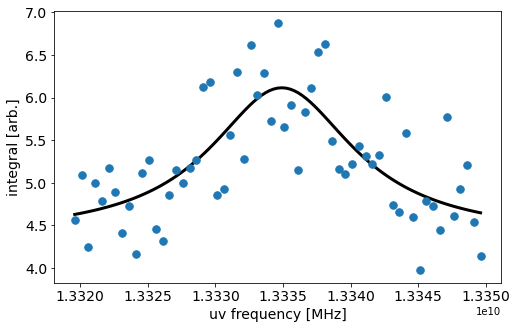

In [152]:
_f = np.linspace(min(f), max(f), 101)

fit_fun = lambda x,a,μ,fwhm,c: a*lorentzian(x,μ,fwhm)+c

popt, pcov = curve_fit(fit_fun, f, v, p0 = [2, 1.3335e10, 20e6, 4])

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_f, fit_fun(_f, *popt), 'k', lw = 3)
ax.plot(f, v, '.', color = 'C0', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

print(f'{popt[1]:.2f}')